## Import & Data Load

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor


train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

In [2]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['month']=df['ATA'].dt.month
    df['hour'] = df['ATA'].dt.hour
    df['weekday'] = df['ATA'].dt.weekday

train['weekday'] = train['weekday'].apply(lambda x: 1 if x >= 5 else 0)
test['weekday'] = test['weekday'].apply(lambda x: 1 if x >= 5 else 0)

# datetime 컬럼 제거
train.drop(columns=['ATA','ID','SHIPMANAGER','FLAG'], inplace=True)
test.drop(columns=['ATA','ID','SHIPMANAGER','FLAG'], inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"): #tqdm? 진행상황 표시 
    le = LabelEncoder() # 카테고리 데이터들을 수치형 데이터로 변환
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_) # 클래스 집합 생성
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist() # 객체 클래스 리스트 생성
    bisect.insort_left(le_classes, '-1') # -1을 리스트에 삽입
    le.classes_ = np.array(le_classes) 
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

train = pd.get_dummies(train,columns=['SHIP_TYPE_CATEGORY'])
test = pd.get_dummies(test,columns=['SHIP_TYPE_CATEGORY'])
# [배 수치항목서 결측치 존재하는 행 제거]
train.dropna(subset=['LENGTH'], inplace=True)
# BUILT,U_WIND,V_WIND 열 제거
train.drop(columns=['BUILT','U_WIND','V_WIND'],axis=1,inplace=True)
test.drop(columns=['BUILT','U_WIND','V_WIND'],axis=1,inplace=True)


Encoding features: 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


Scaling

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_list = ['ARI_CO','ARI_PO','ATA_LT','month']
train[scale_list] = scaler.fit_transform(train[scale_list])
test[scale_list] = scaler.fit_transform(test[scale_list])


In [4]:
# 결측치가 있는 행과 없는 행 분리
X_missing = train[train.isnull().any(axis=1)]
X_no_missing = train.dropna()

# 결측치가 없는 데이터의 특성과 타겟 분리
y_train = X_no_missing[['BN','AIR_TEMPERATURE']]
X_train = X_no_missing[['ARI_CO','ARI_PO','ATA_LT','month']]


# 결측치가 있는 데이터에서 예측할 특성 분리
X_missing_test = X_missing[['ARI_CO','ARI_PO','ATA_LT','month']]

# KNN 회귀 모델 생성 및 훈련
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)

# 결측치 예측
predicted_values = knn_regressor.predict(X_missing_test)

# BN 열과 air_temperature 열의 결측치 인덱스 찾기
bn_nan_indices = train.index[train['BN'].isna()]
air_temp_nan_indices = train.index[train['AIR_TEMPERATURE'].isna()]

# BN 열의 결측치 채우기
for i, idx in enumerate(bn_nan_indices):
    if i < len(predicted_values):  # 배열의 길이를 초과하지 않도록 확인
        train.at[idx, 'BN'] = predicted_values[i, 0]

# air_temperature 열의 결측치 채우기
for i, idx in enumerate(air_temp_nan_indices):
    if i < len(predicted_values):  # 배열의 길이를 초과하지 않도록 확인
        train.at[idx, 'AIR_TEMPERATURE'] = predicted_values[i, 1]


In [5]:
# 결측치 처리 여부
train.isna().sum()

ARI_CO                          0
ARI_PO                          0
DIST                            0
BREADTH                         0
DEADWEIGHT                      0
DEPTH                           0
DRAUGHT                         0
GT                              0
LENGTH                          0
AIR_TEMPERATURE                 0
BN                              0
ATA_LT                          0
PORT_SIZE                       0
CI_HOUR                         0
month                           0
hour                            0
weekday                         0
SHIP_TYPE_CATEGORY_Bulk         0
SHIP_TYPE_CATEGORY_Cargo        0
SHIP_TYPE_CATEGORY_Container    0
SHIP_TYPE_CATEGORY_Tanker       0
dtype: int64

## 각 열의 boxplot을 통해 열 특성 확인

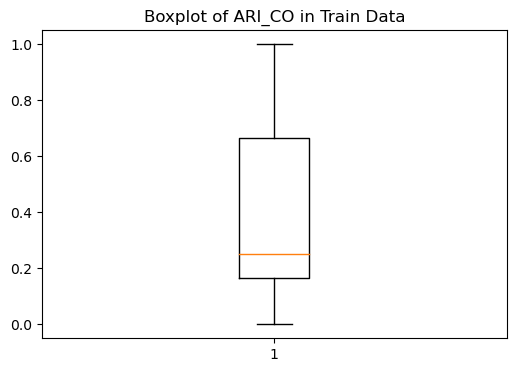

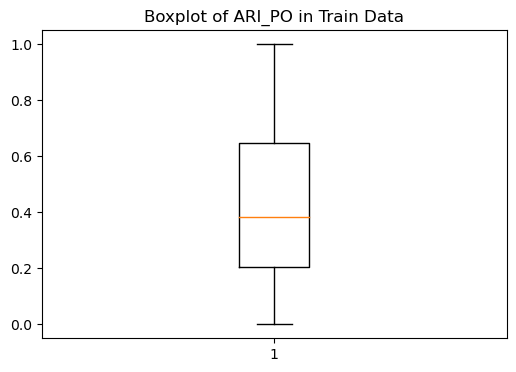

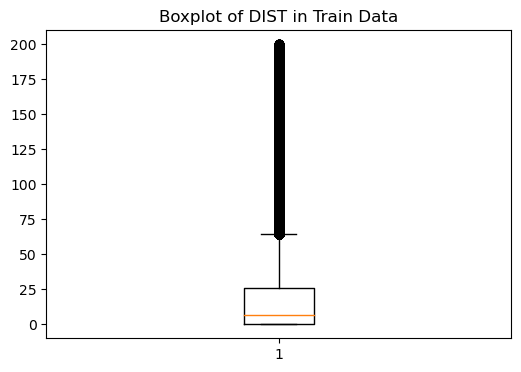

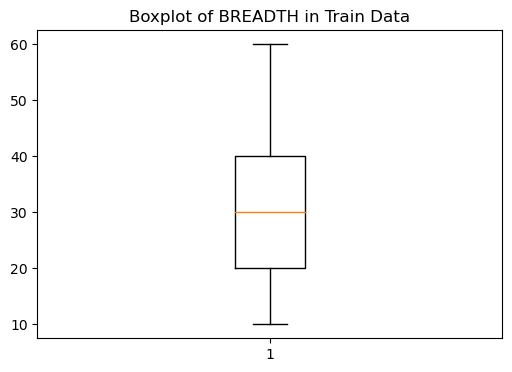

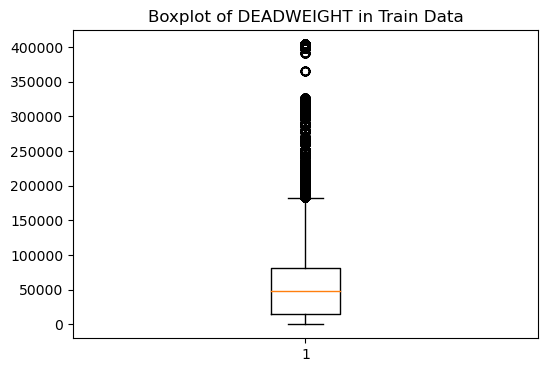

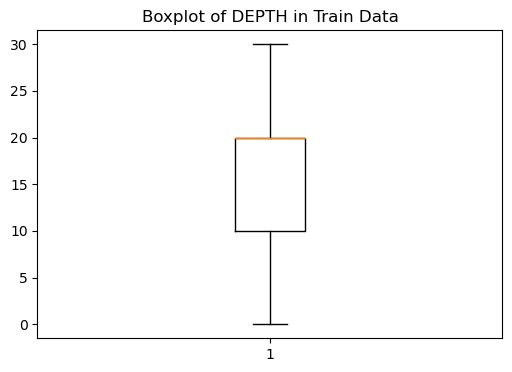

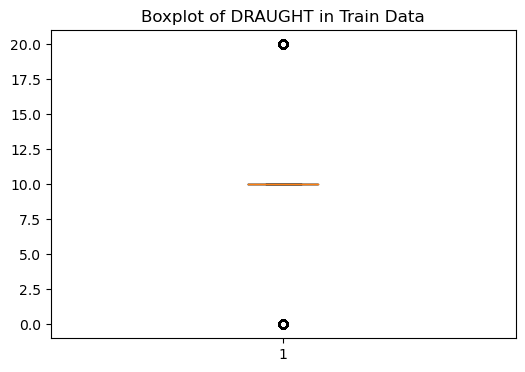

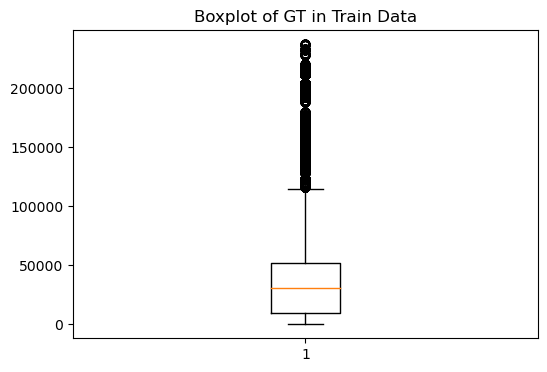

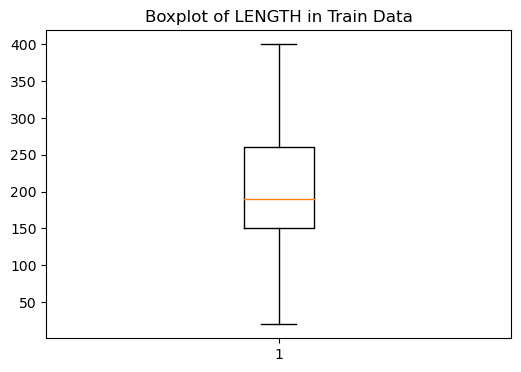

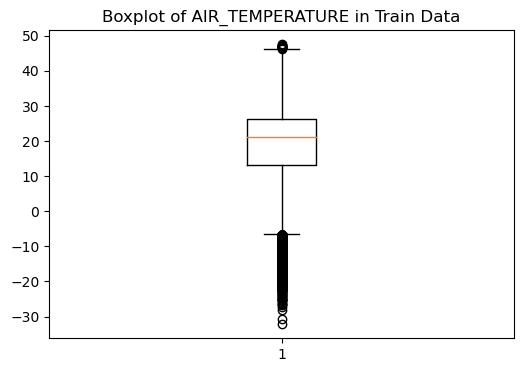

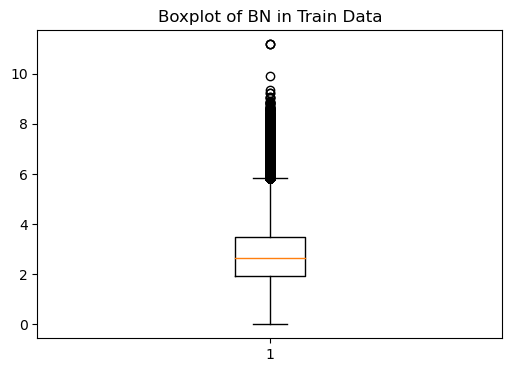

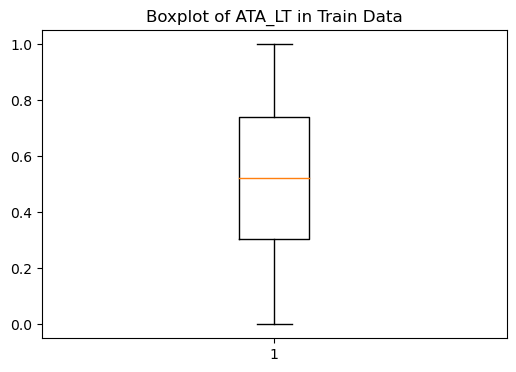

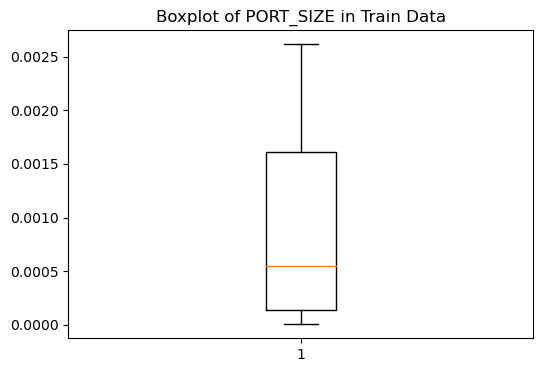

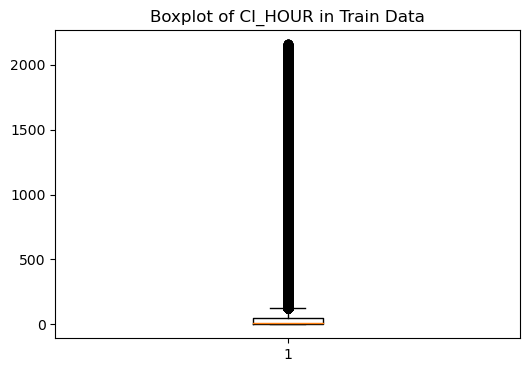

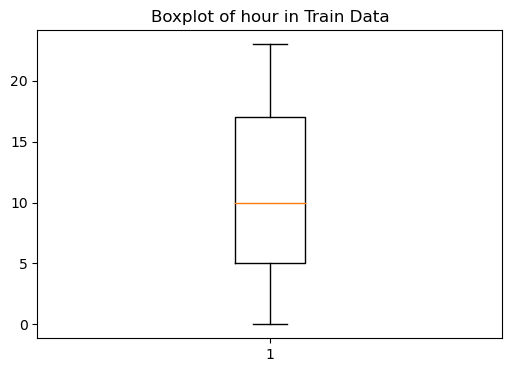

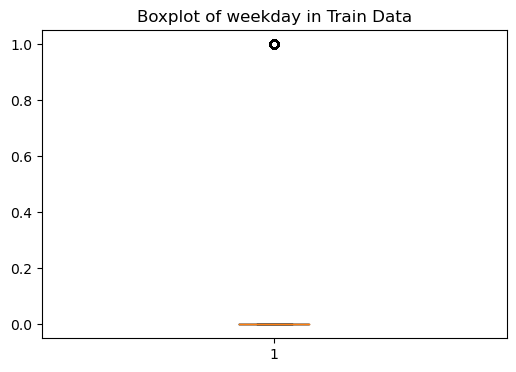

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

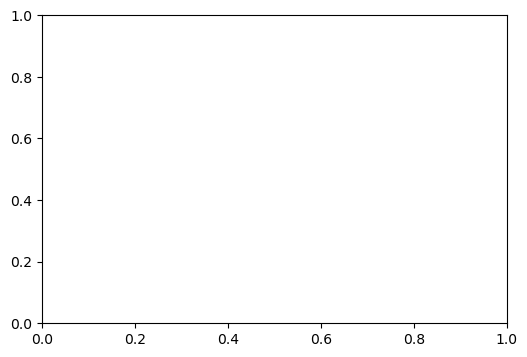

In [28]:
for feature in train.columns:
    plt.figure(figsize=(6, 4))  # 그래프의 크기 설정
    plt.boxplot(train[feature])  # 현재 feature에 대한 boxplot 그리기
    plt.title(f'Boxplot of {feature} in Train Data')  # 그래프 제목 설정
    plt.show()

Scaling

In [6]:
train.columns

Index(['ARI_CO', 'ARI_PO', 'DIST', 'BREADTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT',
       'GT', 'LENGTH', 'AIR_TEMPERATURE', 'BN', 'ATA_LT', 'PORT_SIZE',
       'CI_HOUR', 'month', 'hour', 'weekday', 'SHIP_TYPE_CATEGORY_Bulk',
       'SHIP_TYPE_CATEGORY_Cargo', 'SHIP_TYPE_CATEGORY_Container',
       'SHIP_TYPE_CATEGORY_Tanker'],
      dtype='object')

In [8]:
features = ['DIST','BREADTH','DEADWEIGHT','DEPTH','GT','LENGTH','AIR_TEMPERATURE','BN','PORT_SIZE','hour']

In [9]:
# 이상치 존재하는 feature는 RobustScaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.fit_transform(test[features])

## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1624
[LightGBM] [Info] Number of data points in the train set: 391938, number of used features: 20
[LightGBM] [Info] Start training from score 61.940993


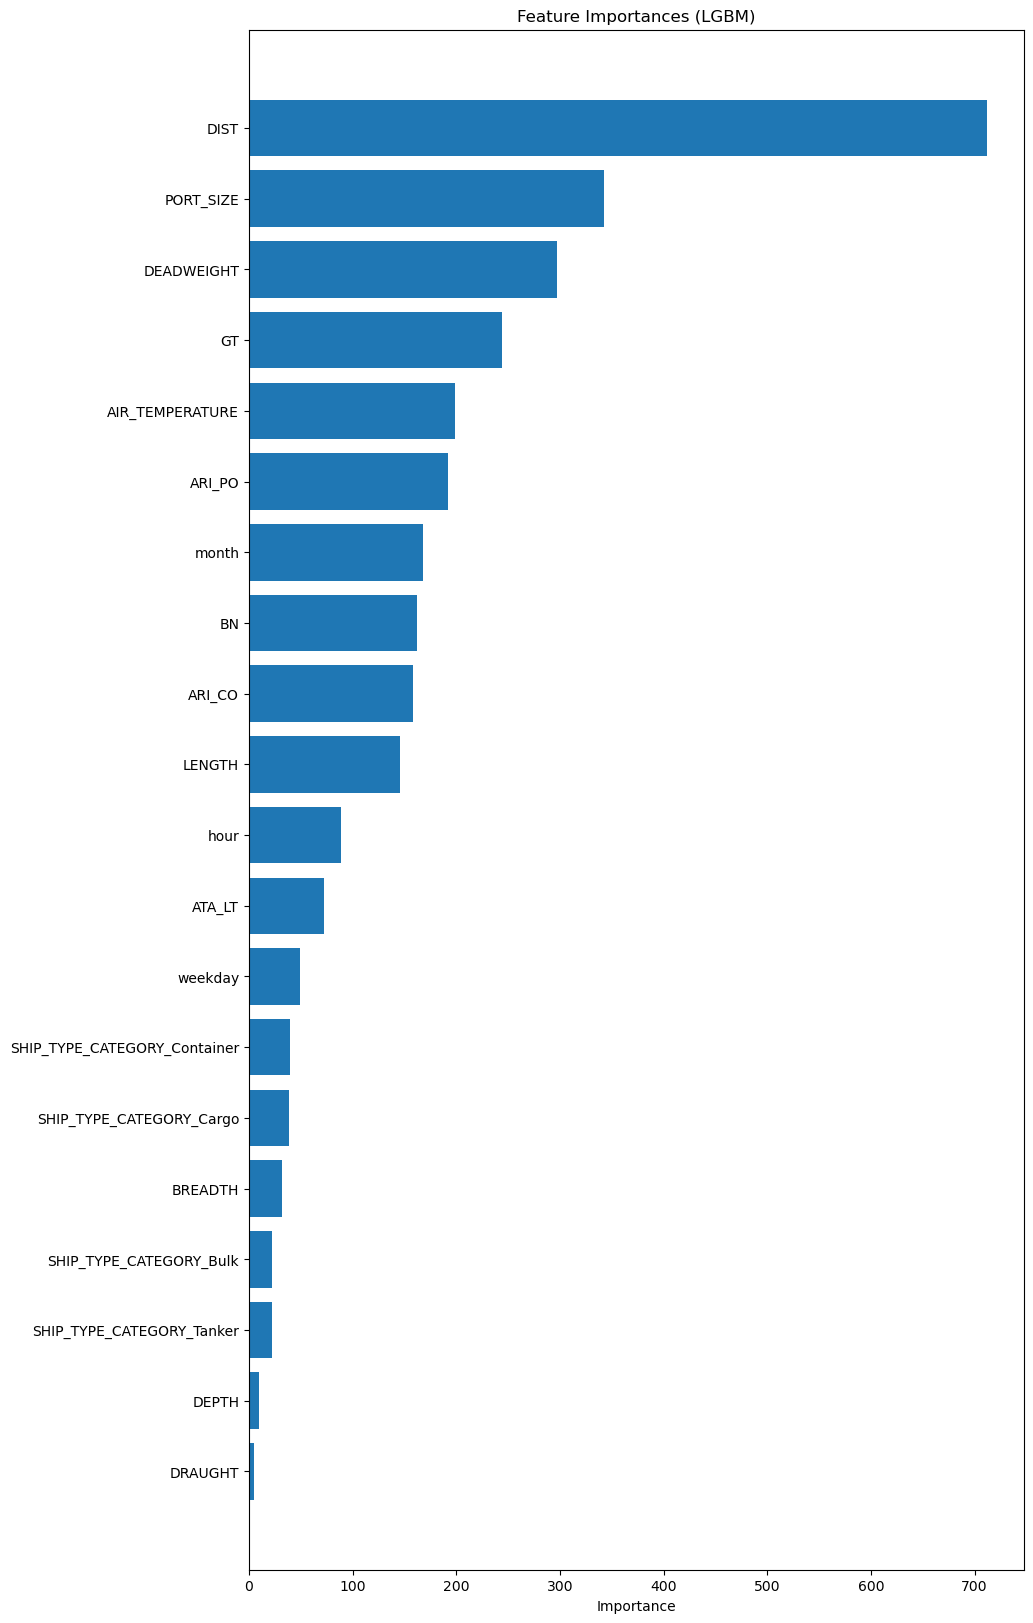

In [10]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


X = train.drop(columns = ['CI_HOUR'])
y = train['CI_HOUR']
k = 5

# Define parameter grid for each model
param_grid_tree = {
    'max_depth': [3, 5, 7]
}

param_grid_forest = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7]
}

param_grid_cat = {
    'iterations': [50, 100, 150],
    'depth': [3, 5, 7]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7]
}

# Models
models = {
    'DecisionTree': (DecisionTreeRegressor(), param_grid_tree),
    'RandomForest': (RandomForestRegressor(), param_grid_forest),
    'CatBoost': (CatBoostRegressor(), param_grid_cat),
    'XGBoost': (XGBRegressor(), param_grid_xgb)
}

# Perform grid search for each model
best_estimators = {}
for name, (model, param_grid) in tqdm(models.items(), desc='Optimizing models'):
    grid_search = GridSearchCV(model, param_grid, cv=k, scoring='neg_mean_absolute_error')
    grid_search.fit(X, y)
    best_estimators[name] = grid_search.best_estimator_

# Print best parameters for each model
for name, estimator in best_estimators.items():
    print(f'Best parameters for {name}: {estimator.get_params()}')

Optimizing models:   0%|          | 0/4 [00:00<?, ?it/s]

Optimizing models:  50%|█████     | 2/4 [1:17:41<1:31:18, 2739.30s/it]

Learning rate set to 0.5
0:	learn: 163.3418063	total: 50.5ms	remaining: 2.47s
1:	learn: 160.4498074	total: 61.4ms	remaining: 1.47s
2:	learn: 158.4572774	total: 70.2ms	remaining: 1.1s
3:	learn: 157.4374732	total: 79.3ms	remaining: 912ms
4:	learn: 156.7255631	total: 88.2ms	remaining: 794ms
5:	learn: 155.9947901	total: 96.5ms	remaining: 707ms
6:	learn: 155.5298328	total: 107ms	remaining: 660ms
7:	learn: 155.2420956	total: 116ms	remaining: 607ms
8:	learn: 154.8860598	total: 124ms	remaining: 566ms
9:	learn: 154.6849233	total: 133ms	remaining: 532ms
10:	learn: 154.4295994	total: 141ms	remaining: 499ms
11:	learn: 153.5328602	total: 150ms	remaining: 474ms
12:	learn: 153.3420173	total: 158ms	remaining: 451ms
13:	learn: 153.1757565	total: 168ms	remaining: 432ms
14:	learn: 152.8708620	total: 176ms	remaining: 411ms
15:	learn: 152.8092576	total: 185ms	remaining: 393ms
16:	learn: 152.7569309	total: 193ms	remaining: 375ms
17:	learn: 152.6907915	total: 201ms	remaining: 358ms
18:	learn: 152.6144361	tot

Optimizing models:  75%|███████▌  | 3/4 [1:18:51<25:20, 1520.12s/it]  

89:	learn: 139.8240206	total: 1.46s	remaining: 162ms
90:	learn: 139.6196012	total: 1.48s	remaining: 146ms
91:	learn: 139.5555276	total: 1.5s	remaining: 130ms
92:	learn: 139.4864704	total: 1.52s	remaining: 114ms
93:	learn: 139.4534433	total: 1.53s	remaining: 97.7ms
94:	learn: 139.3714698	total: 1.55s	remaining: 81.4ms
95:	learn: 139.3304649	total: 1.56s	remaining: 65.1ms
96:	learn: 139.2364359	total: 1.58s	remaining: 48.9ms
97:	learn: 139.1968433	total: 1.6s	remaining: 32.6ms
98:	learn: 139.1698620	total: 1.61s	remaining: 16.3ms
99:	learn: 139.0912424	total: 1.63s	remaining: 0us


Optimizing models: 100%|██████████| 4/4 [1:19:39<00:00, 1194.97s/it]

Best parameters for DecisionTree: {'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}
Best parameters for RandomForest: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 7, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Best parameters for CatBoost: {'iterations': 100, 'depth': 7, 'loss_function': 'RMSE'}
Best parameters for XGBoost: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': 

In [ ]:
# Models
model_tree = DecisionTreeRegressor()
model_forest = RandomForestRegressor()
model_cat = CatBoostRegressor()
model_xgb = XGBRegressor()

# Hyper Parameters
k = 5
models = [model_tree, model_forest, model_cat, model_xgb]


kfold = KFold(n_splits = k)

n_iter = 0
models_mae = []
for model in models:
    cv_mae = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        n_iter += 1
        mae = mean_absolute_error(y_test, pred)
        train_size = X_train.shape[0]
        test_size = X_test.shape[0]
        print('\n{0}#{1} 교차검증 MAE :{2}, 학습 데이터 크기: {3}, 검증 데이터 크기: {4}'.format(model,n_iter, mae, train_size, test_size))
        print('{0}#{1} 검증 세트 인덱스 :{2}'.format(model, n_iter, test_index))
        cv_mae.append(mae)
    print(f'## {model}의 평균 검증 MAE: {np.mean(cv_mae)}')
    models_mae.append(np.mean(cv_mae))

## 특성 중요도로부터 Feature Selection

In [ ]:
threshold = 20 # Your Threshold
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

## K-Fold Model Fitting & Validation

In [ ]:
lgbm = lgb.LGBMRegressor()

# 5-Fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]
    
    # 두 모델 모두 학습
    lgbm.fit(X_t, y_t)
    
    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = lgbm.predict(X_val)
    
    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))
    
    # test 데이터셋에 대한 예측 수행 후 저장
    lgbm_pred = lgbm.predict(X_test_reduced)
    lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)
    
    ensemble_predictions.append(lgbm_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))

## Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)